# Classificação das imagens utilizando Redes Residuais pré-treinadas (ResNet)

## Dataset

O dataset escolhido está disponível no [link](https://www.kaggle.com/datasets/ahmedabdellahismail/covid-19-chest-x-ray/data), o qual é composto de **1196** imagens, pertencentes a três classes:

*   Covid
*   Virus
*   Normal

Segue abaixo o código necessário para realizar download do dataset, realizar unzip e excluir arquivos desnecessários:

In [15]:
#!kaggle datasets download -d ahmedabdellahismail/covid-19-chest-x-ray
#!unzip /content/covid-19-chest-x-ray.zip
#!rm /content/covid-19-chest-x-ray.zip

## Imports

In [16]:
#!pip install torch
#!pip install torchinfo
#!pip install torch torchvision Pillow

In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
from torchinfo import summary
from torchvision.models import ResNet18_Weights
%matplotlib inline

mySeed = 42
np.random.seed(mySeed)
torch.manual_seed(mySeed)
torch.cuda.manual_seed(mySeed)

In [18]:
# selecionar a GPU caso exista
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Pré-processamento dos dados

In [19]:
# Define a transformação que será aplicada nas imagens
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Redimensiona as imagens para 224x224 pixels
    transforms.ToTensor()
])

# Realiza o espelhamento horizontal das imagens para gerar mais dados
transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0), # Espelha as imagens horizontalmente
    transforms.Resize((224, 224)), # Redimensiona as imagens para 224x224 pixels
    transforms.ToTensor()
])

# Carrega o dataset da pasta, assumindo que as subpastas são as classes
originalDataset = datasets.ImageFolder(root="Data/", transform=transform)
flippedDataset = datasets.ImageFolder(root="Data/", transform=transform2)

# Concatena os datasets originais e espelhados
dataset = ConcatDataset([originalDataset, flippedDataset])

class_names = originalDataset.classes # [covid, normal, virus]

# Defina a proporção de dados de treinamento e teste
train_ratio = 0.7
validation_ratio = 0.15

# Calcula os tamanhos dos conjuntos de treino e teste
train_size = int(train_ratio * len(dataset))
validation_size = int(validation_ratio * len(dataset))
test_size = len(dataset) - train_size - validation_size

# Divide o dataset em conjuntos de treino e teste
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

# Cria os data loaders para carregar os dados em mini-lotes
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=2, pin_memory=True)

In [20]:
# Conta a quantidade de imagens por classe no conjunto de treinamento
train_class_count = {}

for _, label in train_dataset:
    if label in train_class_count:
        train_class_count[label] += 1
    else:
        train_class_count[label] = 1

# Conta a quantidade de imagens por classe no conjunto de validacao
validation_class_count = {}

for _, label in validation_dataset:
    if label in validation_class_count:
        validation_class_count[label] += 1
    else:
        validation_class_count[label] = 1

# Conta a quantidade de imagens por classe no conjunto de teste
test_class_count = {}
for _, label in test_dataset:
    if label in test_class_count:
        test_class_count[label] += 1
    else:
        test_class_count[label] = 1

# Mostra a quantidade de imagens por classe nos conjuntos de treinamento
print(f'Tamanho do conjunto de treino: {len(train_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de treinamento:")
for class_idx, count in train_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")

# Mostra a quantidade de imagens por classe nos conjuntos de validação
print(f'\nTamanho do conjunto de validação: {len(validation_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de validação:")
for class_idx, count in validation_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")

# Mostra a quantidade de imagens por classe nos conjuntos de teste
print(f'\nTamanho do conjunto de teste: {len(test_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de teste:")
for class_idx, count in test_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")

Tamanho do conjunto de treino: 1674
Quantidade de imagens por classe no conjunto de treinamento:
Classe 2: 611 imagens
Classe 1: 647 imagens
Classe 0: 416 imagens

Tamanho do conjunto de validação: 358
Quantidade de imagens por classe no conjunto de validação:
Classe 2: 132 imagens
Classe 1: 136 imagens
Classe 0: 90 imagens

Tamanho do conjunto de teste: 360
Quantidade de imagens por classe no conjunto de teste:
Classe 2: 123 imagens
Classe 1: 153 imagens
Classe 0: 84 imagens


## Definindo nosso modelo

In [21]:
torch.manual_seed(42) # Define a seed para reprodução dos resultados
torch.cuda.manual_seed(42) # Define a seed para reprodução dos resultados

Full Fine-Tuning: é um método de adaptação de redes neurais pré-treinadas para novos conjuntos de dados. Nesse processo, todos os pesos da rede são ajustados durante o treinamento, permitindo que a rede adapte todas as suas representações aos novos dados. Esse método é particularmente útil quando se dispõe de um conjunto de dados maior, pois permite uma adaptação completa e específica do modelo às novas informações, potencialmente melhorando a performance final.

In [31]:
# Carregando a ResNet-18 pré-treinada
model_ft_full = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modificando a última camada para o número de classes (3 classes)
num_ftrs = model_ft_full.fc.in_features
model_ft_full.fc = nn.Linear(num_ftrs, 3)

model_ft_full = model_ft_full.to(device)

In [32]:
summary(model=model_ft_full,
        input_size=(16, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [16, 3, 224, 224]    [16, 3]              --                   True
├─Conv2d (conv1)                         [16, 3, 224, 224]    [16, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [16, 64, 112, 112]   [16, 64, 112, 112]   128                  True
├─ReLU (relu)                            [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [16, 64, 112, 112]   [16, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [16, 64, 56, 56]     [16, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [16, 64, 56, 56]     [16, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [16, 64, 56, 56]     [16, 64, 56, 56]     36,864               True
│    │    └─BatchN

Congelamento de Camadas (Feature Extraction): é uma técnica de adaptação de redes neurais pré-treinadas onde as camadas iniciais da rede são congeladas, mantendo seus pesos fixos, e apenas a última camada é treinada. Isso significa que a maior parte da rede utiliza as representações já aprendidas de grandes conjuntos de dados, enquanto a última camada é ajustada para se adaptar ao novo conjunto de dados.

In [24]:
# Carregando a ResNet-18 pré-treinada
model_ft_fe = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Congelando todos os parâmetros da rede
for param in model_ft_fe.parameters():
    param.requires_grad = False

# Modificando a última camada para o número de classes (3 classes)
num_ftrs = model_ft_fe.fc.in_features
model_ft_fe.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft_fe.to(device)

In [25]:
summary(model=model_ft_fe,
        input_size=(16, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [16, 3, 224, 224]    [16, 3]              --                   Partial
├─Conv2d (conv1)                         [16, 3, 224, 224]    [16, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [16, 64, 112, 112]   [16, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [16, 64, 112, 112]   [16, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [16, 64, 56, 56]     [16, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [16, 64, 56, 56]     [16, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [16, 64, 56, 56]     [16, 64, 56, 56]     (36,864)             False
│    │    

Funções de treinamento e validação


In [26]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

# Passo de treino
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    model.train()

    train_loss, train_acc = 0, 0

    # Passa por cada mini-lote
    for batch, (X, y) in enumerate(dataloader):
        # Envia os dados para o dispositivo de hardware
        X, y = X.to(device), y.to(device)

        y_pred = model(X) # Etapa de forward

        # Calcula e acumula a loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Zera os gradientes
        optimizer.zero_grad()

        # Calcula os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()

        # Calcula e acumula a acurácia
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Calcula a média da loss e acurácia
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    model.eval() # Coloca o modelo em modo de avaliação
    val_loss, val_acc = 0, 0

    with torch.inference_mode():
        # Passa por cada mini-lote
        for batch, (X, y) in enumerate(dataloader):
            # Envia os dados para o dispositivo de hardware
            X, y = X.to(device), y.to(device)

            # Etapa de forward
            y_pred = model(X)

            # Calcula e acumula a loss
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()

            # Calcula e acumula a acurácia
            val_pred_labels = y_pred.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # Calcula a média da loss e acurácia
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []
    }

    model.to(device)

    # Loop de treinamento
    for epoch in tqdm(range(epochs)):
        # Treina o modelo
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)

        # Avalia o modelo
        val_loss, val_acc = val_step(model=model,
                                    dataloader=val_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

        # Imprime as métricas
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"val_loss: {val_loss:.4f} | "
          f"val_acc: {val_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    return results

def predict(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:

    model.eval()

    all_preds = []
    all_targets = []

    with torch.inference_mode():
        # Passa por cada mini-lote
        for batch, (X, y) in enumerate(dataloader):
            # Envia os dados para o dispositivo de hardware
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            all_preds.append(y_pred)
            all_targets.append(y)

    # Concatena as predições e as classes
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    return all_preds, all_targets

Treinamento Full Fine-Tuning

In [33]:
# Define o otimizador e a função de loss
optimizer = torch.optim.Adam(params=model_ft_full.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Treina o modelo
ResNet_results_full = train(model=model_ft_full,
                    train_dataloader=train_loader,
                    val_dataloader=validation_loader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=30,
                    device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3471 | train_acc: 0.8764 | val_loss: 0.7230 | val_acc: 0.7111
Epoch: 2 | train_loss: 0.2238 | train_acc: 0.9268 | val_loss: 0.3565 | val_acc: 0.8813
Epoch: 3 | train_loss: 0.1399 | train_acc: 0.9482 | val_loss: 0.1621 | val_acc: 0.9457
Epoch: 4 | train_loss: 0.1273 | train_acc: 0.9526 | val_loss: 0.1828 | val_acc: 0.9303
Epoch: 5 | train_loss: 0.1043 | train_acc: 0.9589 | val_loss: 0.4477 | val_acc: 0.8297
Epoch: 6 | train_loss: 0.0899 | train_acc: 0.9657 | val_loss: 0.2928 | val_acc: 0.8813
Epoch: 7 | train_loss: 0.1000 | train_acc: 0.9588 | val_loss: 0.3053 | val_acc: 0.8958
Epoch: 8 | train_loss: 0.0957 | train_acc: 0.9673 | val_loss: 0.0741 | val_acc: 0.9783
Epoch: 9 | train_loss: 0.0480 | train_acc: 0.9863 | val_loss: 0.3035 | val_acc: 0.8949
Epoch: 10 | train_loss: 0.0325 | train_acc: 0.9881 | val_loss: 0.1735 | val_acc: 0.9438
Epoch: 11 | train_loss: 0.0448 | train_acc: 0.9854 | val_loss: 0.4528 | val_acc: 0.8560
Epoch: 12 | train_loss: 0.1285 | train_ac

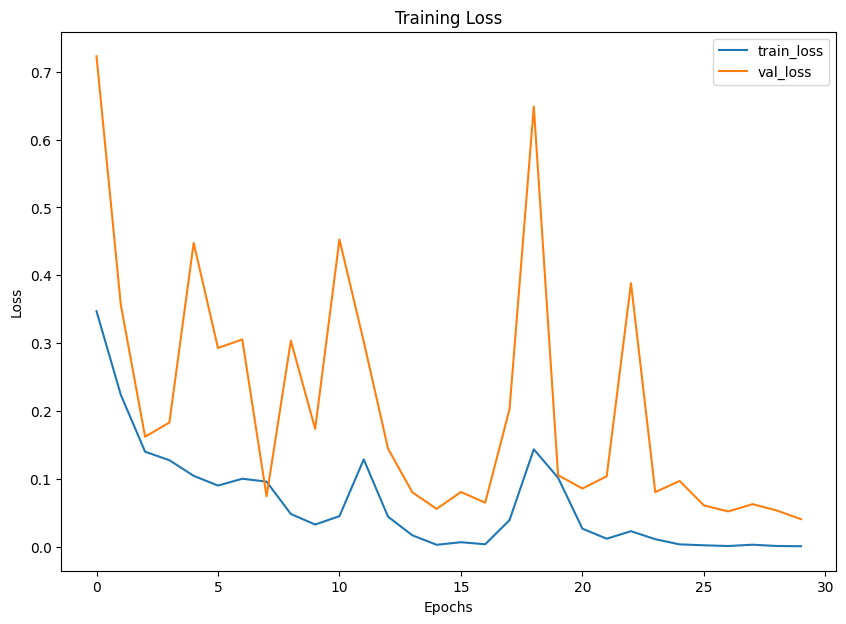

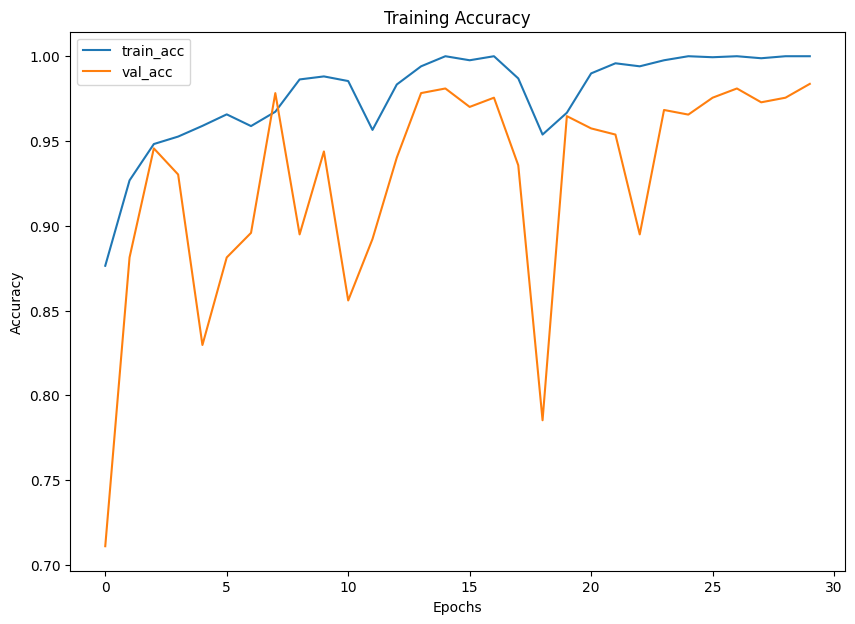

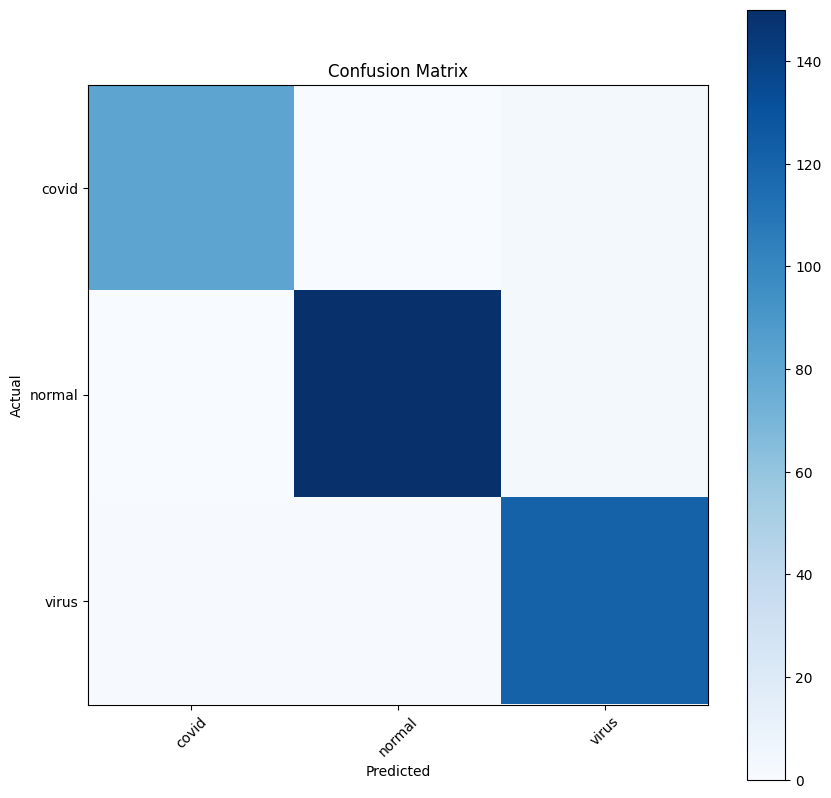

              precision    recall  f1-score   support

       covid       0.99      0.96      0.98        84
      normal       0.99      0.98      0.99       153
       virus       0.95      0.98      0.97       123

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



In [34]:
## Avaliação do modelo

# Plota as métricas de treinamento
plt.figure(figsize=(10, 7))
plt.plot(ResNet_results_full["train_loss"], label="train_loss")
plt.plot(ResNet_results_full["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(ResNet_results_full["train_acc"], label="train_acc")
plt.plot(ResNet_results_full["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Realiza a predição no conjunto de teste
all_preds, all_targets = predict(model=model_ft_full,
                                 dataloader=test_loader,
                                 device=device)

# Calcula a matriz de confusão
conf_matrix = confusion_matrix(all_targets.cpu(), all_preds.argmax(dim=1).cpu())

# Plota a matriz de confusão
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xticks(np.arange(3), class_names, rotation=45)
plt.yticks(np.arange(3), class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Imprime o classification report
print(classification_report(all_targets.cpu(), all_preds.argmax(dim=1).cpu(), target_names=class_names))

Treinamento Congelamento de Camadas (Feature Extraction)

In [29]:
# Define o otimizador e a função de loss
optimizer = torch.optim.Adam(params=model_ft_fe.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Treina o modelo
ResNet_results_fe = train(model=model_ft_fe,
                    train_dataloader=train_loader,
                    val_dataloader=validation_loader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=30,
                    device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5682 | train_acc: 0.7995 | val_loss: 0.3220 | val_acc: 0.9167
Epoch: 2 | train_loss: 0.3134 | train_acc: 0.8990 | val_loss: 0.2484 | val_acc: 0.9293
Epoch: 3 | train_loss: 0.2667 | train_acc: 0.9119 | val_loss: 0.2098 | val_acc: 0.9375
Epoch: 4 | train_loss: 0.2598 | train_acc: 0.9067 | val_loss: 0.2134 | val_acc: 0.9303
Epoch: 5 | train_loss: 0.2150 | train_acc: 0.9300 | val_loss: 0.1958 | val_acc: 0.9330
Epoch: 6 | train_loss: 0.2257 | train_acc: 0.9229 | val_loss: 0.1735 | val_acc: 0.9411
Epoch: 7 | train_loss: 0.2000 | train_acc: 0.9327 | val_loss: 0.2207 | val_acc: 0.9058
Epoch: 8 | train_loss: 0.1816 | train_acc: 0.9417 | val_loss: 0.1450 | val_acc: 0.9520
Epoch: 9 | train_loss: 0.1839 | train_acc: 0.9377 | val_loss: 0.1699 | val_acc: 0.9357
Epoch: 10 | train_loss: 0.2011 | train_acc: 0.9232 | val_loss: 0.1401 | val_acc: 0.9547
Epoch: 11 | train_loss: 0.1872 | train_acc: 0.9339 | val_loss: 0.2060 | val_acc: 0.9275
Epoch: 12 | train_loss: 0.1665 | train_ac

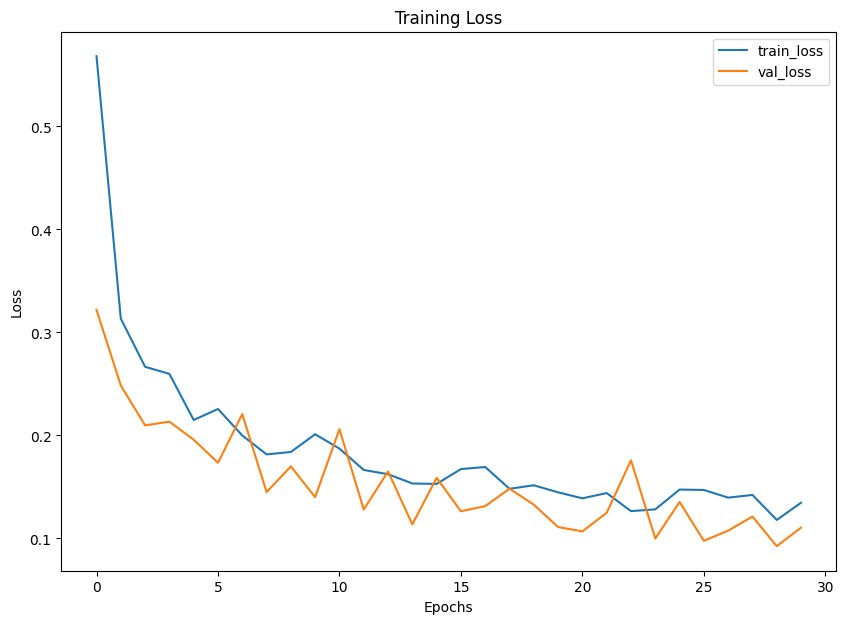

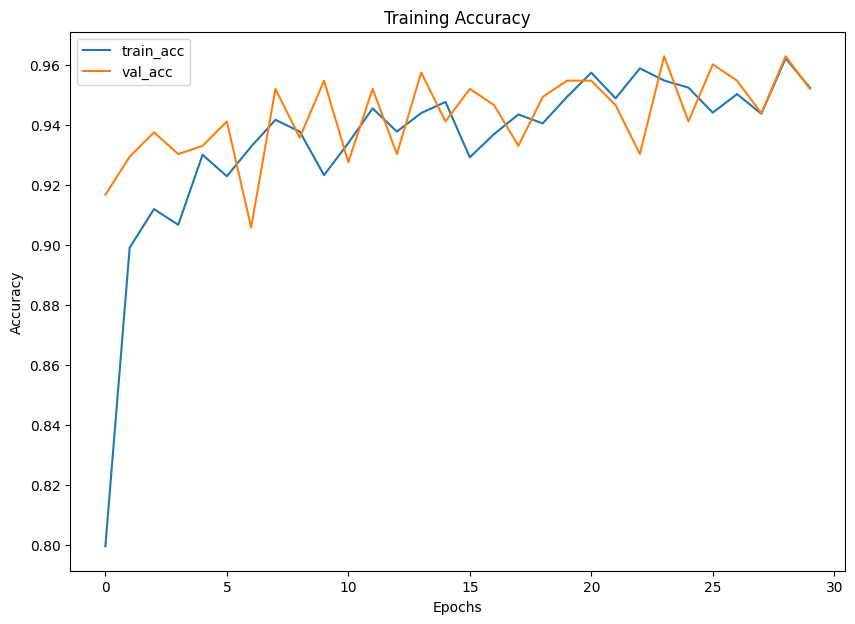

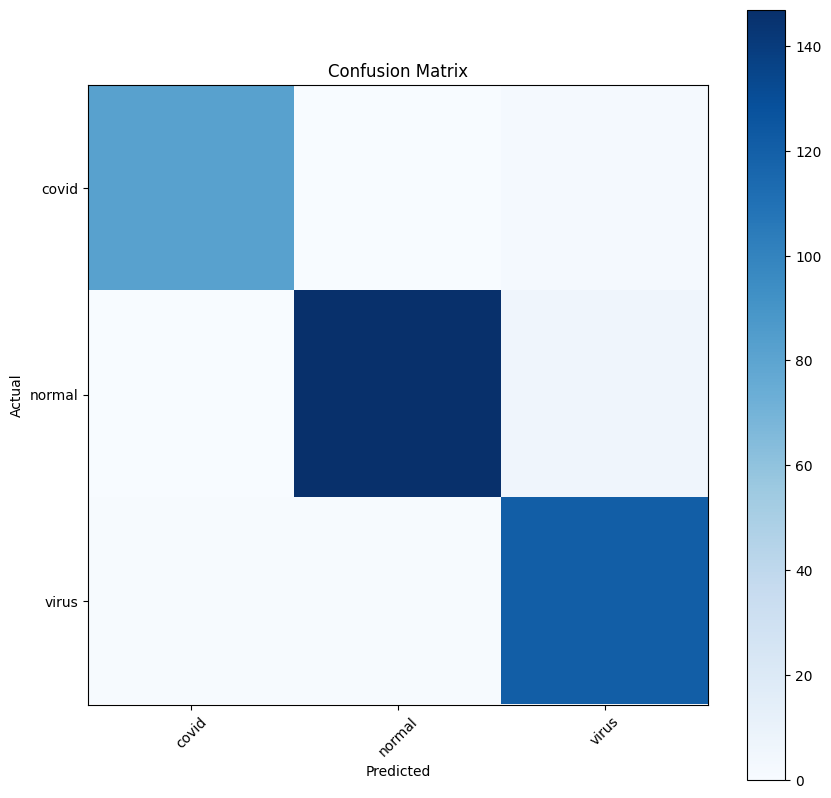

              precision    recall  f1-score   support

       covid       0.99      0.98      0.98        84
      normal       0.99      0.96      0.98       153
       virus       0.94      0.98      0.96       123

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



In [30]:
## Avaliação do modelo

# Plota as métricas de treinamento
plt.figure(figsize=(10, 7))
plt.plot(ResNet_results_fe["train_loss"], label="train_loss")
plt.plot(ResNet_results_fe["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(ResNet_results_fe["train_acc"], label="train_acc")
plt.plot(ResNet_results_fe["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Realiza a predição no conjunto de teste
all_preds, all_targets = predict(model=model_ft_fe,
                                 dataloader=test_loader,
                                 device=device)

# Calcula a matriz de confusão
conf_matrix = confusion_matrix(all_targets.cpu(), all_preds.argmax(dim=1).cpu())

# Plota a matriz de confusão
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xticks(np.arange(3), class_names, rotation=45)
plt.yticks(np.arange(3), class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Imprime o classification report
print(classification_report(all_targets.cpu(), all_preds.argmax(dim=1).cpu(), target_names=class_names))

Analisando os resultados de treinar uma ResNet18 do zero, realizar Full Fine-Tuning e utilizar o método de Feature Extraction, observamos resultados interessantes. Todos os três métodos de treinamento apresentaram tempos semelhantes e convergiram para resultados similares. As curvas de aprendizado em todos os métodos mostram que os pesos dos modelos convergiram para valores muito bons, porém houve diferenças na suavidade dessa convergência.

Ao treinar uma ResNet18 do zero, notamos picos divergentes na curva de aprendizado, os quais foram mais acentuados do que nos outros métodos. O método de Full Fine-Tuning, apesar de apresentar uma curva de aprendizado mais suave que o método de treinamento do zero, ainda mostrou resultados inferiores ao método de Feature Extraction.

Assim, podemos concluir que esses picos acentuados têm correlação direta com a quantidade limitada de dados no conjunto de dados, o que se mostrou mais evidente nos métodos que exigem mais dados. Portanto, embora todos os métodos tenham alcançado resultados positivos, o melhor método para situações com poucos dados, como a analisada, é o Feature Extraction.